Keyhan Hodaei

In this Notebook we will first implement the Barlow Twins method for self-supervised learning using the CIFAR-10 dataset. 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.utils.data import DataLoader, Subset
import random
from PIL import Image, ImageFilter, ImageOps
import torchsummary
from tqdm.notebook import tqdm 

In [2]:
# Transformations
class GaussianBlur:
    def __init__(self, p):
        self.p = p
        
    def __call__(self, image):
        if random.random() > self.p:
            return image
        
        sigma = random.random() * 1.9 + 0.1
        return image.filter(ImageFilter.GaussianBlur(sigma))
    
class Solarization:
    def __init__(self, p):
        self.p = p
        
    def __call__(self, image):
        if random.random() > self.p:
            return image
        return ImageOps.solarize(image)
    
class Transform:
    def __init__(self):
        self.transform1 = transforms.Compose([
            transforms.RandomResizedCrop(32, scale=(0.5, 1.)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(p=1.),
            Solarization(p=0.),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.transform2 = transforms.Compose([
            transforms.RandomResizedCrop(32, scale=(0.5, 1.)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(p=0.1),
            Solarization(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __call__(self, x):
        return self.transform1(x), self.transform2(x)


# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=Transform())
# test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)
# test_loader = data.DataLoader(test_dataset, batch_size=256, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 39105826.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


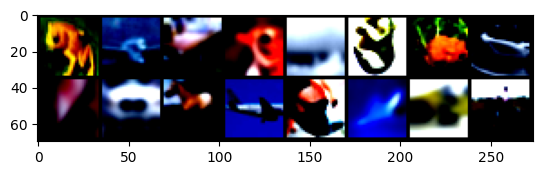

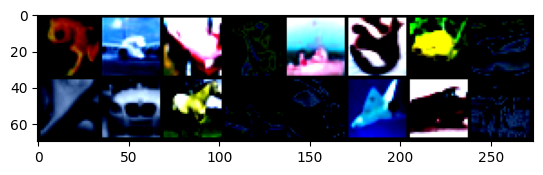

In [3]:
# Visualize the training data
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data = next(train_loader.__iter__())
imshow(torchvision.utils.make_grid(data[0][0][:16]))
imshow(torchvision.utils.make_grid(data[0][1][:16]))

In [7]:
# Implement the Barlow Twins method
class BarlowTwins(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = torchvision.models.resnet50(zero_init_residual=True)
        self.backbone.fc = nn.Identity()
        
        encoder_out_dim = 2048
        # projector_out_dim = 8192
        projector_out_dim = 2048
        
        self.projector = nn.Sequential(
            nn.Linear(encoder_out_dim, projector_out_dim, bias=False),
            nn.BatchNorm1d(projector_out_dim),
            nn.ReLU(inplace=True),
            nn.Linear(projector_out_dim, projector_out_dim, bias=False),
            nn.BatchNorm1d(projector_out_dim),
            nn.ReLU(inplace=True),
            nn.Linear(projector_out_dim, projector_out_dim, bias=False)
        )
        
    def forward(self, x):
        return self.projector(self.backbone(x))
    
class BarlowTwinsLoss(nn.Module):
    def __init__(self , device ,  lambda_: float = 0.01 ) :
        super().__init__()
        self.lambda_ = lambda_
        self.device = device


    def forward(self,
                y1: torch.Tensor,
                y2: torch.Tensor,
                ) -> torch.Tensor:
        
        y1 = (y1 - y1.mean(0)) / y1.std(0)
        y2 = (y2 - y2.mean(0)) / y2.std(0)
        
        N = y1.size(0)
        D = y1.size(1)
        
        c = torch.mm(y1.T, y2) / N
        c_diff = (c - torch.eye(D, device=self.device)).pow(2)
        c_diff[~torch.eye(D, dtype=bool)] *= self.lambda_
        loss = c_diff.sum()
        
        
        return loss


In [9]:
# Define the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BarlowTwins().to(device)
criterion = BarlowTwinsLoss(lambda_=5e-3, device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [10]:
# Train the model
num_epochs = 100

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.
    
    for i, ((x1, x2), _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x1, x2 = x1.to(device), x2.to(device)

        z1, z2 = model(x1), model(x2)
        optimizer.zero_grad()
        loss = criterion(z1, z2)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()


    epoch_loss /= len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1/100, Loss: 227171.5467


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2/100, Loss: 166695.8234


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3/100, Loss: 139380.0924


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4/100, Loss: 122892.5268


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5/100, Loss: 112906.8547


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6/100, Loss: 106316.8421


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7/100, Loss: 99805.6997


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8/100, Loss: 95743.6856


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9/100, Loss: 92077.6662


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10/100, Loss: 89278.6782


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11/100, Loss: 86735.1435


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12/100, Loss: 84148.6016


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13/100, Loss: 82198.2006


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14/100, Loss: 79556.7312


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15/100, Loss: 78549.6692


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16/100, Loss: 77287.0791


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17/100, Loss: 76095.5853


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18/100, Loss: 74713.3106


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19/100, Loss: 73939.5990


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20/100, Loss: 72128.9085


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21/100, Loss: 71211.4911


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22/100, Loss: 70505.4087


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23/100, Loss: 69300.2376


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24/100, Loss: 68523.4085


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25/100, Loss: 68037.4180


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26/100, Loss: 66402.5142


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27/100, Loss: 65820.1563


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28/100, Loss: 65063.6040


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29/100, Loss: 64708.7186


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30/100, Loss: 63667.3416


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31/100, Loss: 63099.2571


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32/100, Loss: 62554.3421


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33/100, Loss: 61576.8717


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34/100, Loss: 61574.1496


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35/100, Loss: 60846.1972


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36/100, Loss: 60248.8216


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37/100, Loss: 59730.3132


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38/100, Loss: 59358.9290


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39/100, Loss: 59191.9321


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40/100, Loss: 58219.7116


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41/100, Loss: 57691.2624


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42/100, Loss: 57222.8479


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43/100, Loss: 56966.2193


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44/100, Loss: 56414.0956


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45/100, Loss: 55993.0989


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46/100, Loss: 56269.8029


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47/100, Loss: 55222.0220


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48/100, Loss: 54915.4577


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49/100, Loss: 54448.1536


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50/100, Loss: 54056.5235


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51/100, Loss: 53899.9199


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52/100, Loss: 53225.6764


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53/100, Loss: 53145.5937


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54/100, Loss: 52861.7606


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55/100, Loss: 52355.1587


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56/100, Loss: 52416.7464


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57/100, Loss: 51818.0524


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58/100, Loss: 51410.4266


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59/100, Loss: 51680.2696


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 60/100, Loss: 51033.4805


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 61/100, Loss: 50673.5086


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 62/100, Loss: 50678.6437


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 63/100, Loss: 49703.7222


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 64/100, Loss: 49549.6579


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 65/100, Loss: 49623.2900


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 66/100, Loss: 49257.5461


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 67/100, Loss: 49188.4985


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 68/100, Loss: 48891.8606


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 69/100, Loss: 48720.3766


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 70/100, Loss: 48446.1620


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 71/100, Loss: 47876.9254


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 72/100, Loss: 47788.2644


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 73/100, Loss: 47621.1437


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 74/100, Loss: 47415.1030


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 75/100, Loss: 47191.3504


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 76/100, Loss: 47084.8697


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 77/100, Loss: 46722.8854


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 78/100, Loss: 46320.7322


  0%|          | 0/196 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
# Save the model
torch.save(model.state_dict(), 'barlow_twins.pth')

Now that we have trained the model, we can use the learned representations to train a linear classifier on the CIFAR-10 dataset.

In [35]:
# Linear classifier
class LinearClassifier(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.backbone = model.backbone
        layers = list(model.projector.children())[:-1]
        self.projector = nn.Sequential(*layers)
        self.fc = nn.Linear(2048, 10)
        self.classifier = nn.Sequential(self.projector, self.fc, nn.Softmax(dim=1))
        
    def forward(self, x):
        return self.classifier(self.backbone(x))
    
pretrained_barlow_twins = BarlowTwins().to(device)
pretrained_barlow_twins.load_state_dict(torch.load('barlow_twins.pth'))

classifier = LinearClassifier(pretrained_barlow_twins).to(device)

for param in classifier.backbone.parameters():
    param.requires_grad = False
for param in classifier.projector.parameters():
    param.requires_grad = False
    
torchsummary.summary(classifier, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

<ipython-input-35-f1a775d9fc6f>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_barlow_twins.load_state_dict(torch.load('barlow_twins.pth'))


In [36]:
# Loading training dataset with new transformations for the linear classifier
new_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10(root='./new_data', train=True, download=True, transform=new_transform)
val_dataset = datasets.CIFAR10(root='./new_data', train=False, download=True, transform=new_transform)

train_loader = DataLoader(
    Subset(val_dataset, range(int(0.8*len(val_dataset)))), 
    batch_size=256, 
    shuffle=True 
)
val_loader = DataLoader(
    Subset(val_dataset, range(int(0.8*len(val_dataset)), len(val_dataset))),
    batch_size=256,
    shuffle=False
)


Files already downloaded and verified
Files already downloaded and verified


In [37]:
# Train the linear classifier
# print the losses and accuracies in each epoch for both training and validation sets

optimizer = optim.Adam(classifier.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

num_epochs = 30

classifier.train()
for epoch in range(num_epochs):
    epoch_loss = 0.
    epoch_accuracy = 0.
    
    for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        output = classifier(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_accuracy += (output.argmax(1) == y).float().mean().item()
        
    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    
    classifier.eval()
    val_loss = 0.
    val_accuracy = 0.
    
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            
            output = classifier(x)
            loss = criterion(output, y)
            
            val_loss += loss.item()
            val_accuracy += (output.argmax(1) == y).float().mean().item()
            
    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    classifier.train()

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/30, Loss: 2.1654, Accuracy: 0.4255
Validation Loss: 2.0026, Validation Accuracy: 0.5721


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/30, Loss: 1.9543, Accuracy: 0.5806
Validation Loss: 1.9045, Validation Accuracy: 0.6117


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/30, Loss: 1.8999, Accuracy: 0.6044
Validation Loss: 1.8765, Validation Accuracy: 0.6212


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/30, Loss: 1.8765, Accuracy: 0.6171
Validation Loss: 1.8646, Validation Accuracy: 0.6264


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/30, Loss: 1.8660, Accuracy: 0.6273
Validation Loss: 1.8553, Validation Accuracy: 0.6375


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/30, Loss: 1.8561, Accuracy: 0.6312
Validation Loss: 1.8493, Validation Accuracy: 0.6306


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/30, Loss: 1.8477, Accuracy: 0.6361
Validation Loss: 1.8463, Validation Accuracy: 0.6322


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/30, Loss: 1.8432, Accuracy: 0.6390
Validation Loss: 1.8420, Validation Accuracy: 0.6339


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/30, Loss: 1.8356, Accuracy: 0.6466
Validation Loss: 1.8397, Validation Accuracy: 0.6361


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/30, Loss: 1.8333, Accuracy: 0.6497
Validation Loss: 1.8374, Validation Accuracy: 0.6361


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/30, Loss: 1.8308, Accuracy: 0.6497
Validation Loss: 1.8351, Validation Accuracy: 0.6400


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/30, Loss: 1.8266, Accuracy: 0.6560
Validation Loss: 1.8339, Validation Accuracy: 0.6380


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/30, Loss: 1.8258, Accuracy: 0.6521
Validation Loss: 1.8324, Validation Accuracy: 0.6411


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/30, Loss: 1.8203, Accuracy: 0.6589
Validation Loss: 1.8319, Validation Accuracy: 0.6400


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/30, Loss: 1.8195, Accuracy: 0.6599
Validation Loss: 1.8307, Validation Accuracy: 0.6372


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/30, Loss: 1.8185, Accuracy: 0.6609
Validation Loss: 1.8293, Validation Accuracy: 0.6443


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/30, Loss: 1.8139, Accuracy: 0.6630
Validation Loss: 1.8277, Validation Accuracy: 0.6470


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/30, Loss: 1.8135, Accuracy: 0.6648
Validation Loss: 1.8279, Validation Accuracy: 0.6467


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/30, Loss: 1.8098, Accuracy: 0.6680
Validation Loss: 1.8273, Validation Accuracy: 0.6415


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/30, Loss: 1.8091, Accuracy: 0.6697
Validation Loss: 1.8261, Validation Accuracy: 0.6415


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/30, Loss: 1.8052, Accuracy: 0.6746
Validation Loss: 1.8259, Validation Accuracy: 0.6415


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/30, Loss: 1.8057, Accuracy: 0.6713
Validation Loss: 1.8241, Validation Accuracy: 0.6416


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/30, Loss: 1.8062, Accuracy: 0.6735
Validation Loss: 1.8248, Validation Accuracy: 0.6422


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/30, Loss: 1.8035, Accuracy: 0.6747
Validation Loss: 1.8248, Validation Accuracy: 0.6422


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/30, Loss: 1.8031, Accuracy: 0.6787
Validation Loss: 1.8247, Validation Accuracy: 0.6451


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/30, Loss: 1.8008, Accuracy: 0.6764
Validation Loss: 1.8240, Validation Accuracy: 0.6426


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27/30, Loss: 1.7986, Accuracy: 0.6825
Validation Loss: 1.8238, Validation Accuracy: 0.6433


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/30, Loss: 1.7977, Accuracy: 0.6815
Validation Loss: 1.8255, Validation Accuracy: 0.6427


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/30, Loss: 1.7987, Accuracy: 0.6782
Validation Loss: 1.8232, Validation Accuracy: 0.6451


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/30, Loss: 1.7960, Accuracy: 0.6836
Validation Loss: 1.8221, Validation Accuracy: 0.6439


In [38]:
torch.save(classifier.state_dict(), 'linear_classifier.pth')